In [1]:
import json
import os
import operator
import re
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
base_path = '../../data'
fig_path = 'figures'
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
with open(os.path.join(base_path, 'tsa_processed.json')) as f:
    text_segments = json.load(f)

In [3]:
# calculate some basic stats

# over all
entity_counts_total = dict()
for typ in ['a', 'p', 'v', 'c']:
    entity_counts_total[typ] = defaultdict(int)
annotation_type_lengths = defaultdict(list)
annotation_dists = defaultdict(list)
# per context
context_lengths = []
annotation_type_counts_per_context = defaultdict(list)


def relation_distance(e_dict, r_dict):
    """ Given an entity dictionary (id to entity)
        and a relation tuple (entity_id, entity_id)
        return the distances between surface forms
        in number of characters.
    """
    
    dists = []
    
    for surf_source in e_dict[r_dict['source']]['surface_forms']:
        source_offset = (
            surf_source['start'],
            surf_source['end']
        )
        for surf_target in e_dict[r_dict['target']]['surface_forms']:
            target_offset = (
                surf_target['start'],
                surf_target['end']
            )
            if source_offset[0] < target_offset[0]:
                # [0]property[1] ---> [0] entity [1]
                # [0] value  [1] ---> [0]property[1]
                #             |         |
                dist = source_offset[1] - target_offset[0]
                # -> negative value
                # for e.g.
                # - the beta1 of Adam is set to ...
                # - we use 0.001 for the learning rate of ...
            else:
                # [0] entity [1] <--- [0]property[1]
                # [0]property[1] <--- [0] value  [1]
                #             |        |
                #             +--------|---+
                #               +------+   |
                #               |          |
                dist = source_offset[0] - target_offset[1]
                # -> positive value
                # for e.g.
                # - for Adam we set beta1 to ...
                # - we set beta1 to 0.9
            dists.append(dist)
    return dists


def annot_distances(annot):
    """ Return distances between
            entities -> properties
        and
            properties -> values
    """
    
    r_dict = annot['relations']
    e_dict = annot['entities']
    dists = {
        'ap': [],
        'pv': [],
        'vc': [],
        'apv': []
    }
    # single hops (a<-p / p<-v)
    for rel in r_dict.values():
        source_type = e_dict[rel['source']]['type']
        target_type = e_dict[rel['target']]['type']
        key = target_type+source_type
        if key in ['ap', 'pv', 'vc']:
            dists_tmp = relation_distance(e_dict, rel)
            dists[key].extend(dists_tmp)
    # douple hops (e<-p<-v)
    for rel1 in r_dict.values():
        for rel2 in r_dict.values():
            if rel1['target'] == rel2['source']:
                e_val = e_dict[rel1['source']]
                e_prop = e_dict[rel1['target']]
                e_ent = e_dict[rel2['target']]
                key = e_ent['type']+e_prop['type']+e_val['type']
                if key == 'apv':
                    # ent to prop
                    dists1 = relation_distance(e_dict, rel2)
                    # prop to val
                    dists2 = relation_distance(e_dict, rel1)
                    for d1 in dists1:
                        for d2 in dists2:
                            dists['apv'].append(
                                (d1, d2)
                            )
    return dists


for txt_seg in text_segments:
    context_lengths.append(len(txt_seg['text']))
    for typ in ['a', 'p', 'v', 'c']:
        annots = [
            e for e in txt_seg['annotation']['entities'].values()
            if e['type'] == typ
        ]
        annotation_type_counts_per_context[typ].append(
            len(annots)
        )
    for e in txt_seg['annotation']['entities'].values():
        for surf in e['surface_forms']:
            entity_counts_total[e['type']][surf['surface_form']] += 1
            annotation_type_lengths[e['type']].append(len(surf['surface_form']))
    dists = annot_distances(txt_seg['annotation'])
    for k, v in dists.items():
        annotation_dists[k].extend(v)

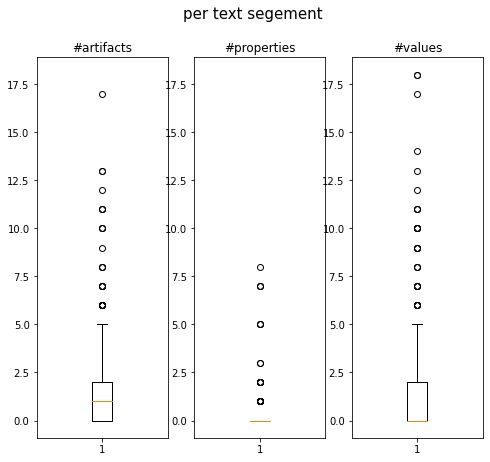

In [4]:
# plot text span stats

# print(stats.describe(context_lengths))
# fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(12, 7))
fig = plt.figure(figsize=(8, 7))
fig.suptitle('per text segement', fontsize=15)
# ax1 = fig.add_subplot(141) 
# ax1.set_title('length (#chars)')
# ax1.boxplot(context_lengths)
ax2 = fig.add_subplot(131)
ax2.set_title('#artifacts')
ax2.boxplot(annotation_type_counts_per_context['a'])
ax3 = fig.add_subplot(132, sharey=ax2) 
ax3.set_title('#properties')
ax3.boxplot(annotation_type_counts_per_context['p'])
ax4 = fig.add_subplot(133, sharey=ax2) 
ax4.set_title('#values')
ax4.boxplot(annotation_type_counts_per_context['v'])
plt.savefig(
    os.path.join(fig_path, 'stats_per_text_span.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

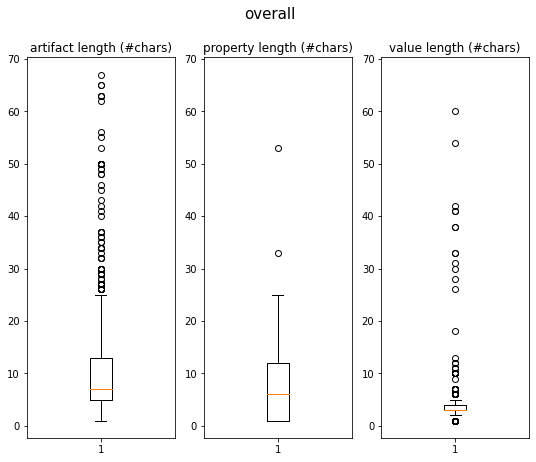

In [5]:
# plot overall annotation type char len statssorted(x.items(), key=operator.itemgetter(1))

fig = plt.figure(figsize=(9, 7))
fig.suptitle('overall', fontsize=15)
ax1 = fig.add_subplot(131) 
ax1.set_title('artifact length (#chars)')
ax1.boxplot(annotation_type_lengths['a'])
ax2 = fig.add_subplot(132, sharey=ax1) 
ax2.set_title('property length (#chars)')
ax2.boxplot(annotation_type_lengths['p'])
ax3 = fig.add_subplot(133, sharey=ax1) 
ax3.set_title('value length (#chars)')
ax3.boxplot(annotation_type_lengths['v'])
plt.savefig(
    os.path.join(fig_path, 'stats_overall.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

In [6]:
# canonicalize frequent yet variably rendered entity names 

entity_counts_total_canon = dict()
entity_counts_total_canon['a'] = defaultdict(int)
nnt_canon_mapping = {
    'adam': 'adam',
    'adaptive moment estimation': 'adam',
    'sgd': 'sgd',
    'gradient descent': 'sgd',
    'stochastic gradient descent': 'sgd',
}
out_of_scope = ['algorithm']
for k, v in entity_counts_total['a'].items():
    kl = k.lower().strip()
    if kl in out_of_scope:
        continue
    if kl in nnt_canon_mapping:
        entity_counts_total_canon['a'][nnt_canon_mapping[kl]] += v
    else:
        entity_counts_total_canon['a'][kl] = v

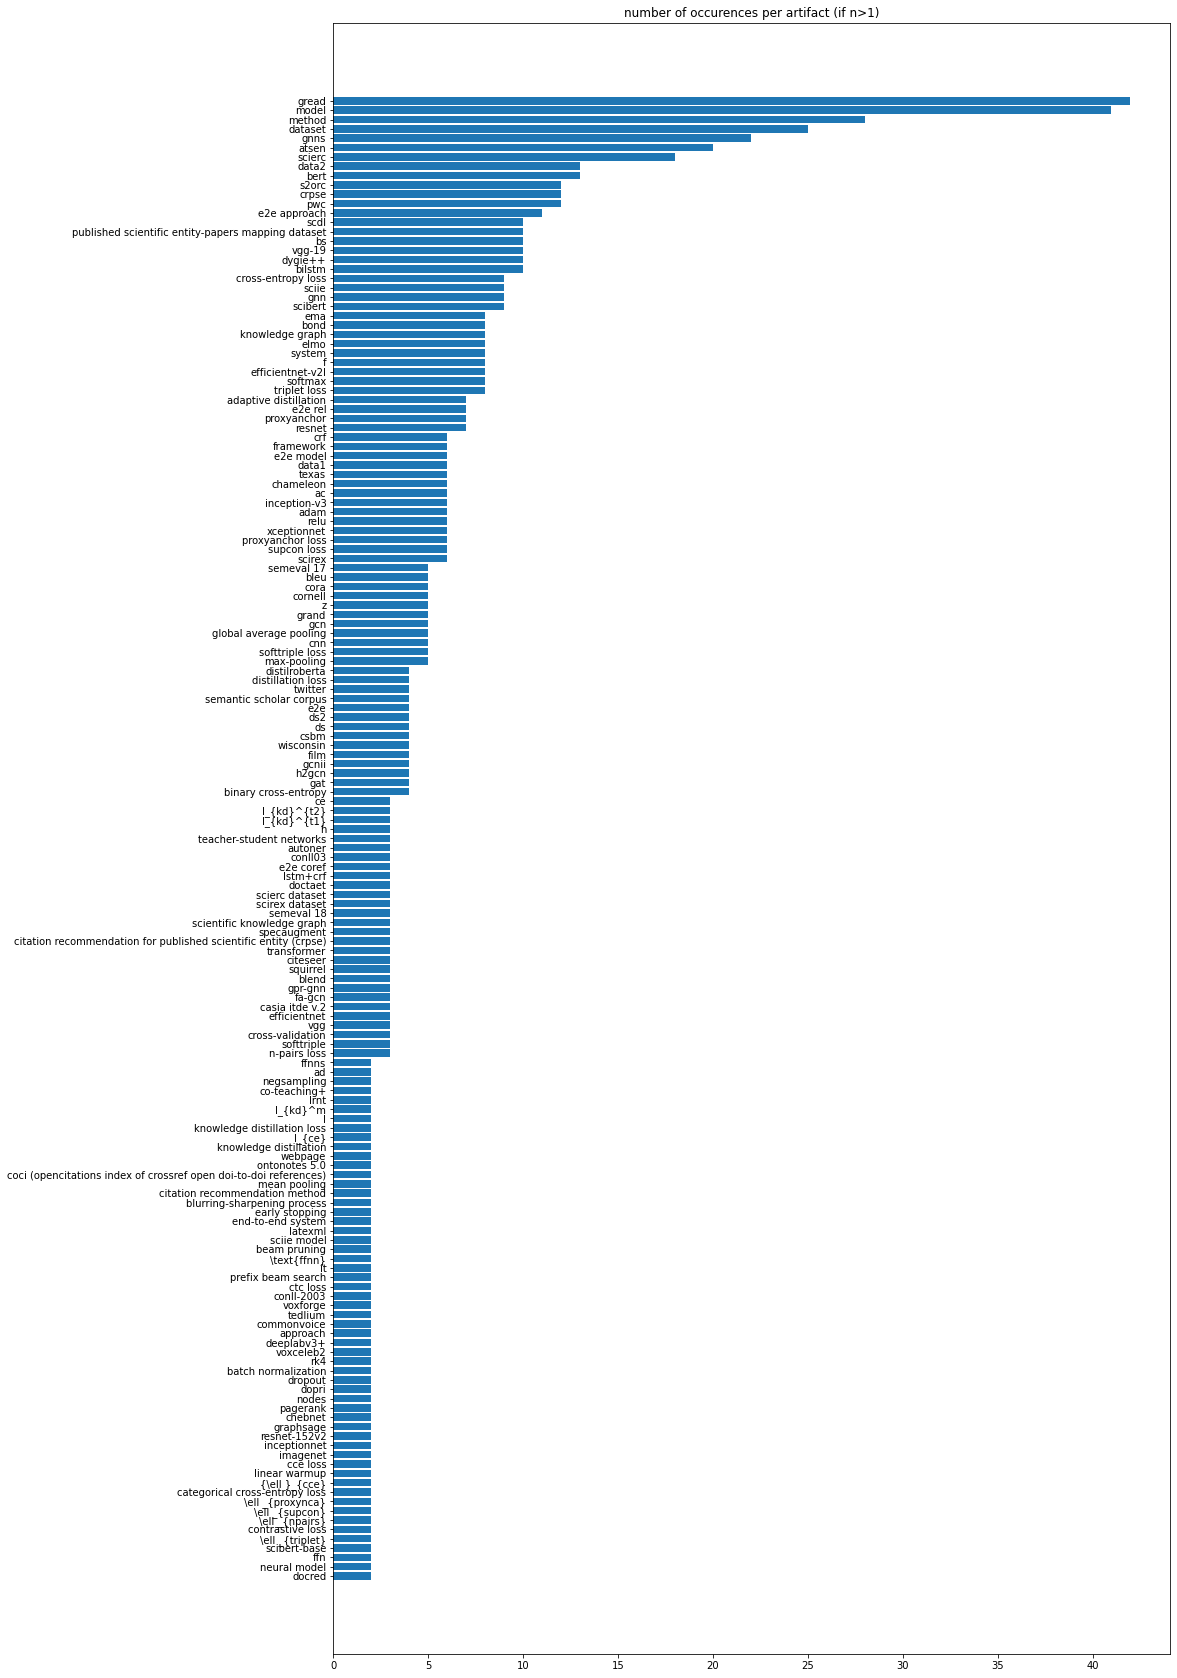

In [7]:
ecounts = sorted(entity_counts_total_canon['a'].items(), key=operator.itemgetter(1))
fig, ax = plt.subplots(figsize=(15,30))
ax.barh(
    [e[0] for e in ecounts if e[1] > 1],
    [e[1] for e in ecounts if e[1] > 1]
)
ax.set_title('number of occurences per artifact (if n>1)')
plt.savefig(
    os.path.join(fig_path, 'stats_artifact_counts.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

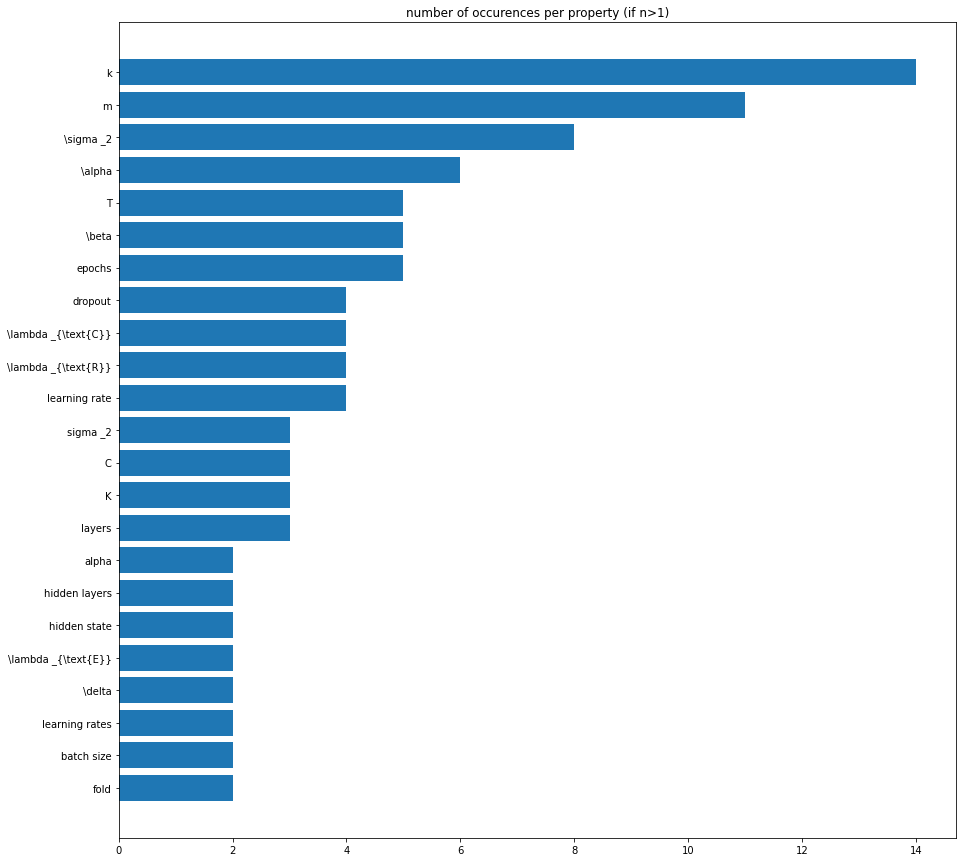

In [8]:
pcounts = sorted(entity_counts_total['p'].items(), key=operator.itemgetter(1))
fig, ax = plt.subplots(figsize=(15,15))
ax.barh(
    [e[0] for e in pcounts if e[1] > 1],
    [e[1] for e in pcounts if e[1] > 1]
)
ax.set_title('number of occurences per property (if n>1)')
plt.savefig(
    os.path.join(fig_path, 'stats_property_counts.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

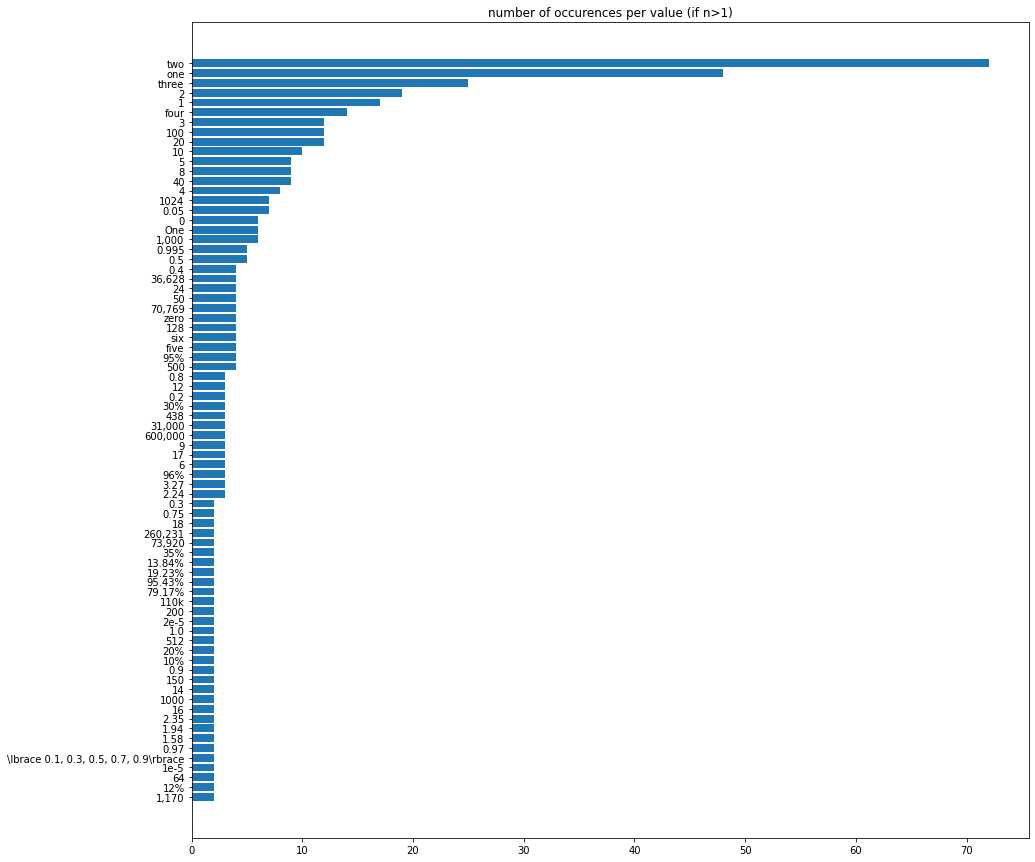

In [9]:
vcounts = sorted(entity_counts_total['v'].items(), key=operator.itemgetter(1))
fig, ax = plt.subplots(figsize=(15,15))
ax.barh(
    [e[0] for e in vcounts if e[1] > 1],
    [e[1] for e in vcounts if e[1] > 1]
)
ax.set_title('number of occurences per value (if n>1)')
plt.savefig(
    os.path.join(fig_path, 'stats_value_counts.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

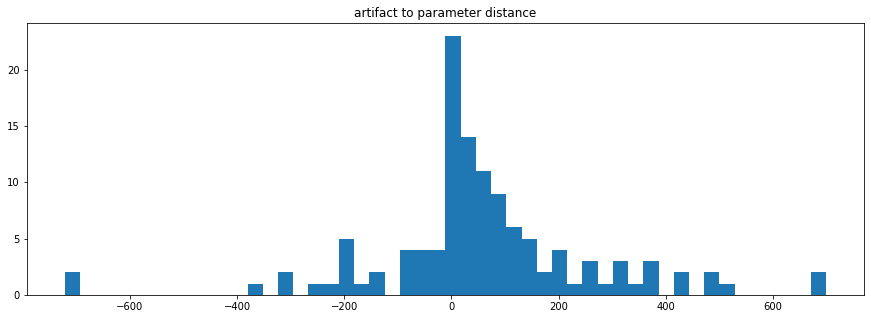

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(annotation_dists['ap'], bins=50)
ax.set_title('artifact to parameter distance')
plt.savefig(
    os.path.join(fig_path, 'stats_artifact_param_distance.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

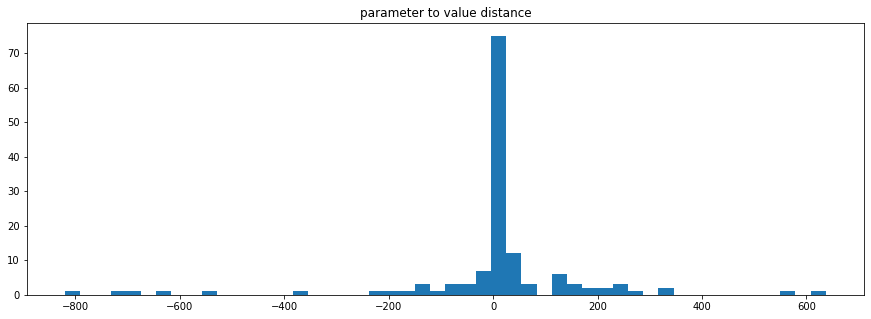

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(annotation_dists['pv'], bins=50)
ax.set_title('parameter to value distance')
plt.savefig(
    os.path.join(fig_path, 'stats_param_value_distance.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

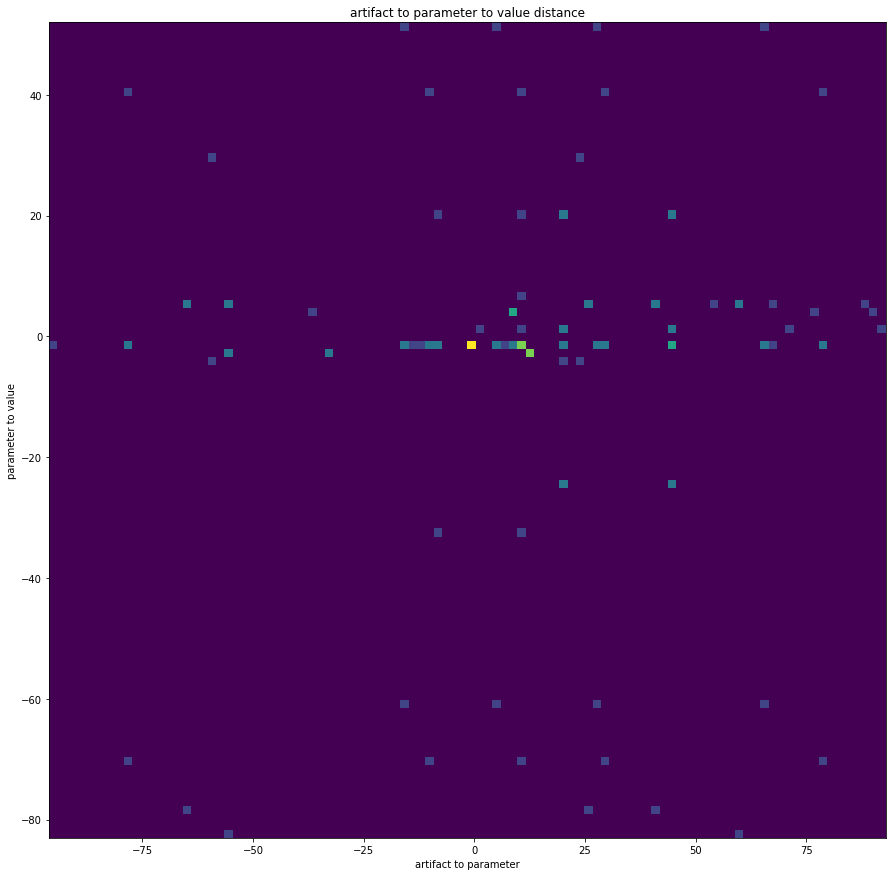

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
lim = 100
ax.hist2d(
    [d[0] for d in annotation_dists['apv'] if abs(d[0])<=lim and abs(d[1])<=lim],
    [d[1] for d in annotation_dists['apv'] if abs(d[0])<=lim and abs(d[1])<=lim],
    bins=lim)
ax.set_title('artifact to parameter to value distance')
ax.set_xlabel('artifact to parameter')
ax.set_ylabel('parameter to value')
plt.savefig(
    os.path.join(fig_path, 'stats_artifact_param_value_distance.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

In [16]:
# get number of annotations
print('{} annotated paragraphs'.format(len(text_segments)))
print('{} relations'.format(
    len(annotation_dists['ap']) +
    len(annotation_dists['pv']) +
    len(annotation_dists['vc'])
))
print('{} annots'.format(
    sum(entity_counts_total['a'].values()) +
    sum(entity_counts_total['p'].values()) +
    sum(entity_counts_total['v'].values()) +
    sum(entity_counts_total['c'].values())
))

print('{} a<-p<-v triples'.format(len(annotation_dists['apv'])))
print('{} a<-p tuples'.format(len(annotation_dists['ap'])))
print('{} p<-v tuples'.format(len(annotation_dists['pv'])))
print('{} v<-c tuples'.format(len(annotation_dists['vc'])))

print('{} a annots'.format(sum(entity_counts_total['a'].values())))
print('{} p annots'.format(sum(entity_counts_total['p'].values())))
print('{} v annots'.format(sum(entity_counts_total['v'].values())))
print('{} c annots'.format(sum(entity_counts_total['c'].values())))

444 annotated paragraphs
323 relations
1971 annots
232 a<-p<-v triples
120 a<-p tuples
137 p<-v tuples
66 v<-c tuples
1134 a annots
131 p annots
662 v annots
44 c annots


In [15]:
# get types of values
vcounts = sorted(entity_counts_total['v'].items(), key=operator.itemgetter(1), reverse=True)
basic_number_patt = re.compile(
    r'^-?\s*'
    r'(\d{1,3}(,\d{3})*|\d+)?'
    r'(\.\d+)?$'
)
plain_e_notation_patt = re.compile(
    r'^-?\d+\s*'
    r'e\s*'
    r'-?\d+$'
)
plain_fraction_patt = re.compile(r'^-?\d+/-?\d+$')
latex_power_patt = re.compile(
    r'^-?'
    r'\d+(\.\d+)?'
    r'e?\^'
    r'{?-?\d+}?$'
)
plain_range_patt = re.compile(
    r'^[\[\{(]\s*'
    r'-?\s*'
    r'(\d{1,3}(,\d{3})*|\d+)?'
    r'(\.\d+)?'
    r'\s*,\s*'
    r'-?\s*'
    r'(\d{1,3}(,\d{3})*|\d+)?'
    r'(\.\d+)?'
    r'\s*[\]\})]$'
)
latex_keyword_patt = re.compile(r'\\[a-z]+')
for v, count in vcounts:
    if not basic_number_patt.match(v) and \
            not plain_e_notation_patt.match(v) and \
            not plain_fraction_patt.match(v) and \
            not latex_power_patt.match(v) and \
            not plain_range_patt.match(v):
        print(v)
#             not plain_power_patt.match(v) and \
#     if latex_keyword_patt.search(v):
#         print(latex_keyword_patt.findall(v))

two
one
three
four
One
95%
five
six
zero
96%
30%
12%
\lbrace 0.1, 0.3, 0.5, 0.7, 0.9\rbrace
10%
20%
110k
79.17%
95.43%
19.23%
13.84%
35%
5K
83%
15%
2%
24%
50%
98.5%
55%
80%
\lbrace 1e-5, 2e-5, 3e-5\rbrace
\lbrace 8,16,64,128\rbrace
6%
\lbrace 1, 3 ,5, 7, 9\rbrace
\lbrace 5, 25, 1,000, 2000\rbrace
\lbrace 0.01, 0.03, 0.05, 0.07, 0.1\rbrace
\lbrace 1,3,3.3,4,6,\\8,10\rbrace
\lbrace 0.1, 0.3, 0.5, 0.7, 0.9, 1\rbrace
\lbrace 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 5\rbrace
\lbrace 16, 32, 64, 128\rbrace
\lbrace 0, 0.1, 0.3, 0.5, 0.7, 0.9\rbrace
63%
64%
75%
500k
95.46%
93.51%
97.35%
89.67%
99.6%
90.75%
97.71%
90.87%
96.36%
93.15%
12.25%
18.72%
8.8%
28.91%
2.39%
30.03%
5.98%
28.48%
9.67%
21.05%
74.9%
77.1%
1, 5 or 10
eight
34%
36%
7%
23%
2.72%
19.96%
300%
40%
seven
76.9%
67.8%
63.8%
1.5k
84%
70%
gelu
{32, 64, 128, 256}
1.0 to 4.0
1e-4 to 2e-2
0 to 0.01
76.4%
81.1 million
8.1 million
380.5 million
Two
1.3%
2.4%
1.8%
2.7%
13.1%
7.4%
4.5%
7.1%
4.9%
1.99%
2.84%
[3\mathrm {e}{-5}, 5\mathrm {e